# **IMPORT DATA**

In [18]:
# import data from google drive :) 
 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 160)  # to display all columns of our data 

from sklearn.ensemble import RandomForestRegressor  # modeling 
from sklearn.metrics import make_scorer, mean_squared_error  #scoring
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:

train = pd.read_csv('/content/SUPCOM_Train.csv')
test = pd.read_csv('/content/SUPCOM_Test.csv')
Submission = pd.read_csv('/content/SUPCOM_SampleSubmission.csv')

In [21]:
train.shape , test.shape

((21295, 121), (7517, 120))

# **EDA**

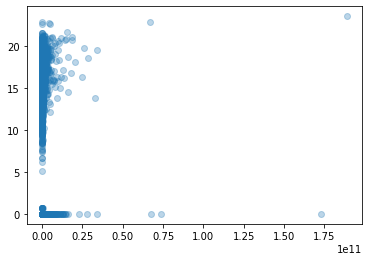

In [22]:
# Look at some scatter plots (only plotting for a subset of data to keep things fast)
sample = train.sample(10000)
plt.scatter(sample['TVA_TOTDUE'], sample['target'], alpha=0.3 , )

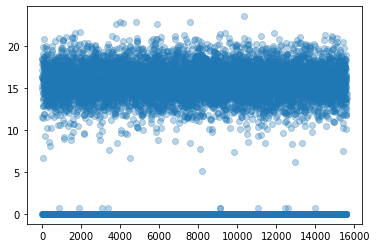

In [23]:
plt.scatter(sample['CTR_MATFIS'], sample['target'], alpha=0.3)

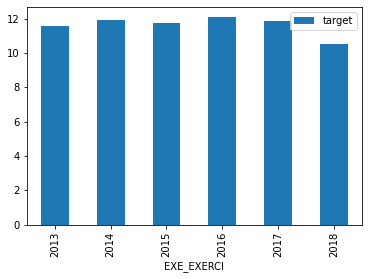

In [24]:
# Plot trend year-on-year
train.groupby('EXE_EXERCI').mean().reset_index().plot(y='target', x='EXE_EXERCI', kind='bar')
                                                #ylim=(0, 0.03))

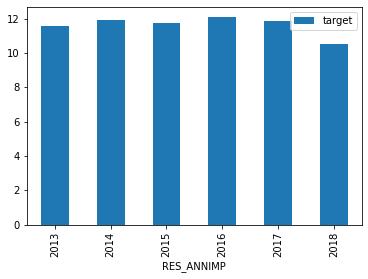

In [25]:
# Plot trend year-on-year
train.groupby('RES_ANNIMP').mean().reset_index().plot(y='target', x='RES_ANNIMP', kind='bar')
                                                #ylim=(0, 0.03))

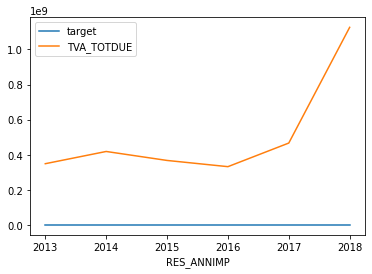

In [26]:
# Let's plot precipitation and burn area on the same plot - note the inverse relationship, and the strong periodic component to both.
ax = train.groupby('RES_ANNIMP').mean().reset_index().plot(y='target', x='RES_ANNIMP')
train.groupby('RES_ANNIMP').mean().reset_index().plot(y='TVA_TOTDUE', x='RES_ANNIMP', ax=ax)

# **Feature  Engineering**

In [27]:
# Label encoder : 

from sklearn.preprocessing import LabelEncoder
train['CTR_CATEGO_X'] = LabelEncoder().fit_transform(train['CTR_CATEGO_X'])
test['CTR_CATEGO_X'] = LabelEncoder().fit_transform(test['CTR_CATEGO_X'])

In [28]:
cols_with_missing = [col for col in train 
                     if (train[col].isnull().sum()>17800)]

In [29]:
train.drop(cols_with_missing, axis=1, inplace=True)
test.drop(cols_with_missing, axis=1, inplace=True)

In [30]:
target = train.target  # TARGET 
testID = test.id       # GET  ID to create our submission correctly 

train.drop(['id','target'],1,inplace=True)
test.drop(['id',],1,inplace=True)           # delete id from test || target & id from train because we haven't target in test :) ->Same shape

In [31]:
train

,BCT_CODBUR,CTR_MATFIS,CTR_CATEGO_X,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,CTR_OBLTFP,CTR_OBLDCO,CTR_OBLTVA,CTR_OFODEC,CTR_OFODEP,CTR_OFODET,CTR_OBLAUT,CTR_OBLASS,CTR_ODTIMB,CTR_OBLTCL,CTR_OBLTHO,CTR_OBLDLI,CTR_OBLTVI,CTR_RATISS,EXE_EXERCI,TVA_CHAFF6,TVA_CHAFF7,TVA_CHAF10,TVA_CHAF12,TVA_CAF125,TVA_CHAF15,TVA_CHAF18,TVA_CHAF22,TVA_CHAF29,TVA_CHAF36,TVA_TOTDUE,TVA_MOIDEB,TVA_CRDINI,TVA_BASIMB,TVA_DEDIMB,TVA_BASEQL,TVA_DEDEQL,TVA_BASEQI,TVA_DEDEQI,TVA_BASAUL,TVA_DEDAUL,TVA_BASAUI,TVA_DEDAUI,TVA_BASRSM,TVA_DEDRSM,TVA_RSNRES,TVA_TRSPOR,TVA_DEDREG,TVA_RESTIT,TVA_MNTPAY,TVA_MOIFIN,TVA_CRDFIN,TVA_ACHSUS,TVA_ACHEXO,TVA_ACHNDD,TVA_CAFEXP,TVA_CAFSUS,TVA_CAFEXO,TVA_AACHAB,TVA_CRDBLQ,TVA_CRDRES,TVA_CRDRMP,TVA_CRDREP,TVA_CRDRMC,TVA_MACHN,TVA_MCESQ,TVA_MTVLSM,TVA_TXVLSM,TVA_MTALSM,TVA_TXALSM,TVA_MTORDTVA,TVA_MTDJRTVA,TVA_MTORDTAX,TVA_MTDJRTAX,TVA_MTRESTAX,TVA_CA072018,TVA_CA132018,TVA_CA192018,ADB_MNTORD,SND_MNTPRD_I,SND_MNTTVA_I,SND_MNTDRC_I,SND_MNTAVA_I,SND_MNTTAX_I,SND_MNTPAY_I,SND_MNTAIR_I,AX1_BRTIMP,AX2_HONORA,AX2_LOYERS,AX3_REVCAP,AX5_MNTMAR,RES_ANNIMP
0,44,6210,0,99,0,3707,4,2,2,2,2,1,2,1.0,1.0,1.0,1.0,1.0,2.0,3,1.0,1.0,1.0,0,2014,0.0,0.0,0.0,126423147.0,0.0,0.0,7.554927e+08,0.0,0.0,0.0,1.511595e+08,1.0,0.0,0.0,0.0,203502320.0,40671108.0,168448614.0,23214917.0,2.376526e+08,39987369.0,52750313.0,7884392.0,7969950.0,3984975.0,0.0,0.0,0.0,0.0,35416705.0,12.0,0.0,0.0,0.0,0.0,37590000.0,610000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,831900.0,192717832.0,24374617.0,0.0,0.0,3947479.0,28322096.0,740196.0,0.0,2950000.0,0.0,0.0,6.027693e+08,2014
1,401,14383,1,22,0,6105,4,2,2,2,2,1,2,1.0,1.0,1.0,1.0,1.0,2.0,3,1.0,1.0,1.0,0,2013,0.0,0.0,0.0,21916400.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,2.629968e+06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.772366e+06,499026.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2130942.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,203353885.0,0.0,0.0,1.478520e+07,2013
2,243,11555,1,23,0,5751,4,2,2,2,2,1,2,2.0,1.0,1.0,1.0,1.0,2.0,3,1.0,1.0,1.0,0,2013,0.0,0.0,0.0,0.0,0.0,0.0,2.037350e+07,0.0,0.0,0.0,3.667230e+06,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.955256e+07,3411102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256128.0,12.0,0.0,0.0,0.0,0.0,0.0,23461000.0,7500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.079280e+07,2013
3,72,6175,0,99,0,4402,4,2,2,2,2,1,2,1.0,1.0,2.0,2.0,1.0,1.0,3,1.0,2.0,1.0,0,2017,61381586.0,0.0,0.0,0.0,0.0,0.0,3.384812e+08,0.0,0.0,0.0,6.460951e+07,1.0,26974794.0,0.0,0.0,0.0,0.0,0.0,0.0,3.062294e+08,55121289.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318095.0,12.0,17804671.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000e+00,2017
4,42,1417,1,23,0,6302,4,2,2,2,2,1,2,1.0,1.0,1.0,1.0,1.0,2.0,3,1.0,1.0,1.0,0,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000e+00,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21290,47,6766,1,22,0,4203,4,2,2,2,2,1,2,1.0,1.0,1.0,1.0,1.0,2.0,3,1.0,1.0,1.0,0,2014,0.0,0.0,0.0,0.0,0.0,0.0,2.281258e+09,0.0,0.0,0.0,4.106264e+08,1.0,15322641.0,0.0,0.0,0.0,0.0,0.0,0.0,1.793527e+09,322834940.0,0.0,0.0,134748105.0,67374052.0,0.0,0.0,84535

**<h3> Fillna : fill Nans with Mean : Not the best Approach but try to get a methodic fillna :) </h3>**

In [32]:
To_convert_to_int = ['CTR_OFODEP','CTR_OFODET','CTR_OBLAUT','CTR_OBLASS','CTR_ODTIMB','CTR_OBLTCL','CTR_OBLTHO','CTR_OBLDLI','CTR_OBLTVI',]
train[To_convert_to_int] = train[To_convert_to_int].fillna(-1)
train[To_convert_to_int] = train[To_convert_to_int].astype('int16')

test[To_convert_to_int] = test[To_convert_to_int].fillna(-1)
test[To_convert_to_int] = test[To_convert_to_int].astype('int16')

train.fillna(train.mean(),inplace=True) # when you work with models like RandomForest assert that you haven't nans in your data 
test.fillna(test.mean(),inplace=True)

# **Modeling : Cross-Validation-LGBM + Prediction**



In [33]:
params ={'colsample_bytree':0.85,'learning_rate':0.03,'max_depth':8,'n_estimators':3000,'num_leaves':150,
                               'silent':False,'metric':'rmse','objective':'regression'}


In [34]:
n_iters = 7

preds_buf = []
err_buf = []
X = train
y=target

categ_features = ['BCT_CODBUR','CTR_MATFIS','FJU_CODFJU','CTR_CESSAT','ACT_CODACT','CTR_OBLDIR','CTR_OBLACP','CTR_OBLRES',
                  
                  'CTR_OBLFOP','CTR_OBLTFP','CTR_OBLDCO','CTR_OBLTVA','CTR_OFODEP','CTR_OFODET','CTR_OBLAUT','CTR_OBLASS',
                  
                  'CTR_ODTIMB','CTR_OBLTCL','CTR_OBLTHO','CTR_OBLDLI','CTR_OBLTVI',]


In [35]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt

In [36]:
for i in range(n_iters): 
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=i)
    d_train = lgb.Dataset(x_train, label=y_train,categorical_feature=categ_features)
    d_valid = lgb.Dataset(x_valid, label=y_valid,categorical_feature=categ_features)

    model = lgb.train(params, d_train,valid_sets=(d_train,d_valid) ,early_stopping_rounds=100 ,verbose_eval=100)

    preds = np.clip(model.predict(x_valid,num_iteration=model.best_iteration) ,a_min=0 , a_max=100)
    
    err = sqrt(mean_squared_error(y_valid, preds))
    err_buf.append(err)
    print('RMSLE = ' + str(err))
    
    ######################################################   " TEST "  ######################################################"
    preds = np.clip(model.predict(test,num_iteration=model.best_iteration ), a_min=0 , a_max=100) 
    preds_buf.append(preds)

print('Mean RMSLE = ' + str(np.mean(err_buf)) + ' +/- ' + str(np.std(err_buf)))
# Average predictions
preds = np.mean(preds_buf, axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 4.97809	valid_1's rmse: 5.96051
[200]	training's rmse: 4.52683	valid_1's rmse: 5.86936
[300]	training's rmse: 4.19044	valid_1's rmse: 5.80275
[400]	training's rmse: 3.94449	valid_1's rmse: 5.76367
[500]	training's rmse: 3.73524	valid_1's rmse: 5.74364
[600]	training's rmse: 3.47873	valid_1's rmse: 5.71954
[700]	training's rmse: 3.29078	valid_1's rmse: 5.70217
[800]	training's rmse: 3.12577	valid_1's rmse: 5.69075
[900]	training's rmse: 2.9625	valid_1's rmse: 5.67864
[1000]	training's rmse: 2.76847	valid_1's rmse: 5.66458
[1100]	training's rmse: 2.64439	valid_1's rmse: 5.65693
[1200]	training's rmse: 2.53487	valid_1's rmse: 5.65051
[1300]	training's rmse: 2.42986	valid_1's rmse: 5.64651
[1400]	training's rmse: 2.33085	valid_1's rmse: 5.64757
Early stopping, best iteration is:
[1300]	training's rmse: 2.42986	valid_1's rmse: 5.64651
RMSLE = 5.641812134092368
Training until validation scores don't improve

# **Create a submission**

In [37]:
Submission_Cross_val_LGB = pd.DataFrame()
Submission_Cross_val_LGB['client_id'] = testID
Submission_Cross_val_LGB['target'] = np.clip(preds ,a_min =0, a_max=100)


print('min' , Submission_Cross_val_LGB['target'].min() )
print('max' , Submission_Cross_val_LGB['target'].max() )
print('mean : ' ,Submission_Cross_val_LGB['target'].mean())

Submission_Cross_val_LGB.to_csv('Submission_Cross_val_LGB_over_17800.csv',index=False)

min 0.0
max 21.418261802457852
mean :  11.983957235470907
